<a href="https://colab.research.google.com/github/shiri9/non-iid/blob/main/data_skew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive

# Mount Google Drive to access data files
drive.mount('/content/drive')

# Load datasets
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_test.csv')

# Define label mapping for attack categories (including all labels from train and test sets)
attack_mapping = {
    'normal': 0, 'neptune': 1, 'land': 1, 'back': 1, 'teardrop': 1, 'pod': 1, 'smurf': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1,  # Missing DoS labels in test set
    'phf': 3, 'multihop': 3, 'warezclient': 3, 'warezmaster': 3, 'spy': 3, 'ftp_write': 3,
    'guess_passwd': 3, 'imap': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4,
    # Ensure all test labels are included
    'mscan': 2, 'saint': 2, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3,
    'httptunnel': 3, 'ps': 4, 'xterm': 4,
    'sendmail': 3, 'named': 3  # Missing labels in test set
}

# Apply the label mapping
df_train['labels'] = df_train['labels'].replace(attack_mapping)
df_test['labels'] = df_test['labels'].replace(attack_mapping)

# Verify the unique labels after mapping
print("Unique labels in train set:", df_train['labels'].unique())
print("Unique labels in test set:", df_test['labels'].unique())

# Dropping the irrelevant column 'num_outbound_cmds'
df_train = df_train.drop('num_outbound_cmds', axis=1)
df_test = df_test.drop('num_outbound_cmds', axis=1)

# Encoding categorical columns: 'protocol_type', 'service', 'flag'
categorical_columns = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])  # Important: use transform for test set, not fit_transform

# Scaling numerical columns
numerical_columns = [
    'duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'hot', 'num_compromised', 'num_root'
]

scaler = MinMaxScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

# Convert to NumPy arrays and enforce correct types for TensorFlow
X_train = np.array(df_train.drop('labels', axis=1)).astype(np.float32)
y_train = np.array(df_train['labels']).astype(np.int32)

X_test = np.array(df_test.drop('labels', axis=1)).astype(np.float32)
y_test = np.array(df_test['labels']).astype(np.int32)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Check dataset shapes
print("Train dataset shape:", X_train.shape, y_train.shape)
print("Test dataset shape:", X_test.shape, y_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unique labels in train set: [0 1 3 2 4]
Unique labels in test set: [0 2 1 3 4]
Train dataset shape: (125973, 40) (125973,)
Test dataset shape: (22544, 40) (22544,)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf


# Number of partitions (clients)
num_partitions = 10

# Get unique classes/labels in the dataset
unique_labels_noniid = df_train['labels'].unique()
num_classes = len(unique_labels_noniid)

# Initialize list to store partitions
data_partitions = []

# For each partition, define how much of each class's data to include
for i in range(num_partitions):
    partition = pd.DataFrame()

    # Iterate through each class
    for label in unique_labels_noniid:
        class_data = df_train[df_train['labels'] == label]

        # Generate random proportion for the current partition and class
        proportion = np.random.uniform(0.01, 0.3)  # Random proportion between 1% and 30%

        # Ensure at least one sample is included for each class
        num_samples = max(1, int(len(class_data) * proportion))

        # Randomly sample this number of instances from the class data
        sampled_data = class_data.sample(n=num_samples, replace=False)

        # Append the sampled data to the current partition
        partition = pd.concat([partition, sampled_data])

    # Shuffle the partition data and reset index
    partition = partition.sample(frac=1).reset_index(drop=True)

    # Add the partition to the list
    data_partitions.append(partition)

    # Display class distribution in this partition
    print(f"Partition {i+1} class distribution:")
    print(partition['labels'].value_counts())
    print()


Partition 1 class distribution:
labels
1    13154
0    11081
2     2508
3      120
4        3
Name: count, dtype: int64

Partition 2 class distribution:
labels
1    5987
0    1969
2    1719
3     161
4      12
Name: count, dtype: int64

Partition 3 class distribution:
labels
0    17218
1    10931
2     1823
3      253
4       13
Name: count, dtype: int64

Partition 4 class distribution:
labels
0    16970
1     9301
2     2587
3      110
4        9
Name: count, dtype: int64

Partition 5 class distribution:
labels
0    7142
1    6424
2     414
3     112
4       1
Name: count, dtype: int64

Partition 6 class distribution:
labels
1    13659
0     5855
2      964
3      278
4        8
Name: count, dtype: int64

Partition 7 class distribution:
labels
0    16246
1     4619
2     1103
3      139
4       13
Name: count, dtype: int64

Partition 8 class distribution:
labels
0    11924
1    11163
2     1489
3       21
4       12
Name: count, dtype: int64

Partition 9 class distribution:
labels
0  

In [ ]:
# Create TensorFlow Datasets for each partition with validation datasets
batch_size = 32  # Set your desired batch size
train_datasets = []
val_datasets = []

for partition in data_partitions:
    # Split each partition into training and validation subsets (90% train, 10% validation)
    len_partition = len(partition)
    len_train = int(0.9 * len_partition)

    # Shuffle the partition
    partition = partition.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the partition into training and validation
    train_partition = partition.iloc[:len_train]
    val_partition = partition.iloc[len_train:]

    # Extract features and labels
    train_features = train_partition.drop(columns=['labels']).values.astype(np.float32)
    train_labels = train_partition['labels'].values.astype(np.int32)

    val_features = val_partition.drop(columns=['labels']).values.astype(np.float32)
    val_labels = val_partition['labels'].values.astype(np.int32)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(batch_size)

    # Append datasets to the list
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

# Create a TensorFlow Dataset for the test dataset
test_features = df_test.drop(columns=['labels']).values.astype(np.float32)
test_labels = df_test['labels'].values.astype(np.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size)

# Now you have `train_datasets`, `val_datasets`, and `test_dataset` ready for TensorFlow


In [ ]:
import tensorflow as tf

# Define the neural network using the Keras API
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.fc1 = tf.keras.layers.Dense(128, activation='relu', input_shape=(40,))
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(5)  # Assuming 5 output classes

    def call(self, x):
        # Define the forward pass
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Device setup is automatic in TensorFlow, so no need to explicitly specify DEVICE.

def train(net, dataset, epochs, verbose=False):
    net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    total_loss = 0
    correct = 0
    total = 0

    for epoch in range(epochs):
        history = net.fit(dataset, epochs=1, verbose=verbose)
        total_loss += sum(history.history['loss'])
        accuracy = history.history['accuracy'][-1]

    return total_loss, accuracy

def test(net, dataset):
    results = net.evaluate(dataset, verbose=0)
    return results[0], results[1]  # loss, accuracy

net = Net()

num_clients = 10
epochs = 5
for epoch in range(epochs):
    print(f"Training for epoch {epoch+1}")
    epoch_training_loss = 0.0
    epoch_training_correct = 0
    total_samples = 0

    for i in range(num_clients):
        dataloader = train_datasets[i]
        valloader = val_datasets[i]

        # Train on client data
        train_loss, train_accuracy = train(net, dataloader, 1)
        epoch_training_loss += train_loss * len(dataloader)
        epoch_training_correct += train_accuracy * len(dataloader)
        total_samples += len(dataloader)

        # Validate on client data
        val_loss, val_accuracy = test(net, valloader)
        print(f"Client {i+1} Epoch {epoch+1}: validation loss {val_loss}, accuracy {val_accuracy}")

    # Compute average training loss and accuracy for the epoch
    average_epoch_loss = epoch_training_loss / total_samples
    average_epoch_accuracy = epoch_training_correct / total_samples
    print(f"Epoch {epoch+1} Average Training Loss: {average_epoch_loss:.4f}, "
          f"Average Training Accuracy: {average_epoch_accuracy:.4f}")
    print(f"End of epoch {epoch+1}\n")

# Test the model with the test dataset
loss, accuracy = test(net, test_dataset)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Training for epoch 1
Client 1 Epoch 1: validation loss 0.11901170760393143, accuracy 0.9653888940811157
Client 2 Epoch 1: validation loss 0.16082696616649628, accuracy 0.9573603868484497
Client 3 Epoch 1: validation loss 0.08907050639390945, accuracy 0.971230149269104
Client 4 Epoch 1: validation loss 0.07903999835252762, accuracy 0.9755003452301025
Client 5 Epoch 1: validation loss 0.05331173166632652, accuracy 0.9851064085960388
Client 6 Epoch 1: validation loss 0.05809736251831055, accuracy 0.9821858406066895
Client 7 Epoch 1: validation loss 0.0561702661216259, accuracy 0.9796563982963562
Client 8 Epoch 1: validation loss 0.035852789878845215, accuracy 0.9882161617279053
Client 9 Epoch 1: validation loss 0.038344766944646835, accuracy 0.9863066077232361
Client 10 Epoch 1: validation loss 0.04422174021601677, accuracy 0.9838465452194214
Epoch 1 Average Training Loss: 0.0909, Average Training Accuracy: 0.9716
End of epoch 1

Training for epoch 2
Client 1 Epoch 2: validation loss 0.04

In [ ]:
!pip install tensorflow-federated

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff
import collections

# Define the Keras model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(40,)),  # Assuming 40 features
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # Assuming 5 output classes
    ])
    return model

In [ ]:
# Preprocessing function to handle batching with padding
def preprocess(dataset):
    def batch_format_fn(features, labels):
        return collections.OrderedDict(
            x=tf.reshape(features, [-1, 40]),  # Flatten features to match input shape
            y=tf.reshape(labels, [-1])  # Reshape labels to match expected shape
        )

    # Pad and batch datasets
    padded_shapes = ([None, 40], [None])  # Correct padded shapes for features and labels
    return dataset.padded_batch(32, padded_shapes=padded_shapes).map(batch_format_fn).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Preprocess the entire test dataset once
preprocessed_test_data = preprocess(test_dataset)

In [ ]:
# Create federated data
def make_federated_data(train_dataset, client_ids):
    federated_data = []
    for i in client_ids:
        dataset_size = len(list(train_dataset[i]))  # Check dataset size
        if dataset_size > 0:  # Ensure the client has data
            federated_data.append(preprocess(train_dataset[i]))
    return federated_data


In [ ]:
# Set the number of clients
NUM_CLIENTS = 10
client_ids = list(range(NUM_CLIENTS))

# Create federated training data
federated_train_data = make_federated_data(train_datasets, client_ids)

In [ ]:
# Model function for federated learning
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


In [ ]:
# Build the federated averaging algorithm
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.001),
    server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01)
)

# Initialize the federated learning process
train_state = training_process.initialize()


In [ ]:
# Set number of training rounds
NUM_ROUNDS = 30

# Training loop for federated learning
for round_num in range(NUM_ROUNDS):
    # Select clients for this round (all clients in this case)
    selected_clients = client_ids

    # # Create federated data for the selected clients
    # federated_train_data = make_federated_data(train_datasets, selected_clients)

    # Run one round of federated training
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state

    # Extract and display the metrics
    train_metrics = result.metrics
    print(f'Round {round_num+1}, Metrics: {train_metrics}')


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.99013287), ('loss', 0.03428444), ('num_examples', 201376), ('num_batches', 202)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9903117), ('loss', 0.033787165), ('num_examples', 201376), ('num_batches', 202)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.99049044), ('loss', 0.033279944), ('num_examples', 201376), ('num_batches', 202)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ()

In [ ]:
# After training, get the global model weights from the federated learning state
model_weights = training_process.get_model_weights(train_state)

# Define a new Keras model (must match the architecture used in federated learning)
keras_model = create_keras_model() # Replace model_fn with create_keras_model()

# Load the TFF model weights into the Keras model
# Access the underlying Keras model using _keras_model
# Note: Assigning to trainable_variables instead of trainable_weights
keras_model.set_weights(model_weights.trainable)


# Compile the Keras model for evaluation
keras_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Evaluate the Keras model on the centralized test dataset
loss, accuracy = keras_model.evaluate(test_dataset, verbose=0)

# Print the evaluation metrics
print(f'Test Dataset Evaluation - Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

Test Dataset Evaluation - Loss: 0.757, Accuracy: 0.926


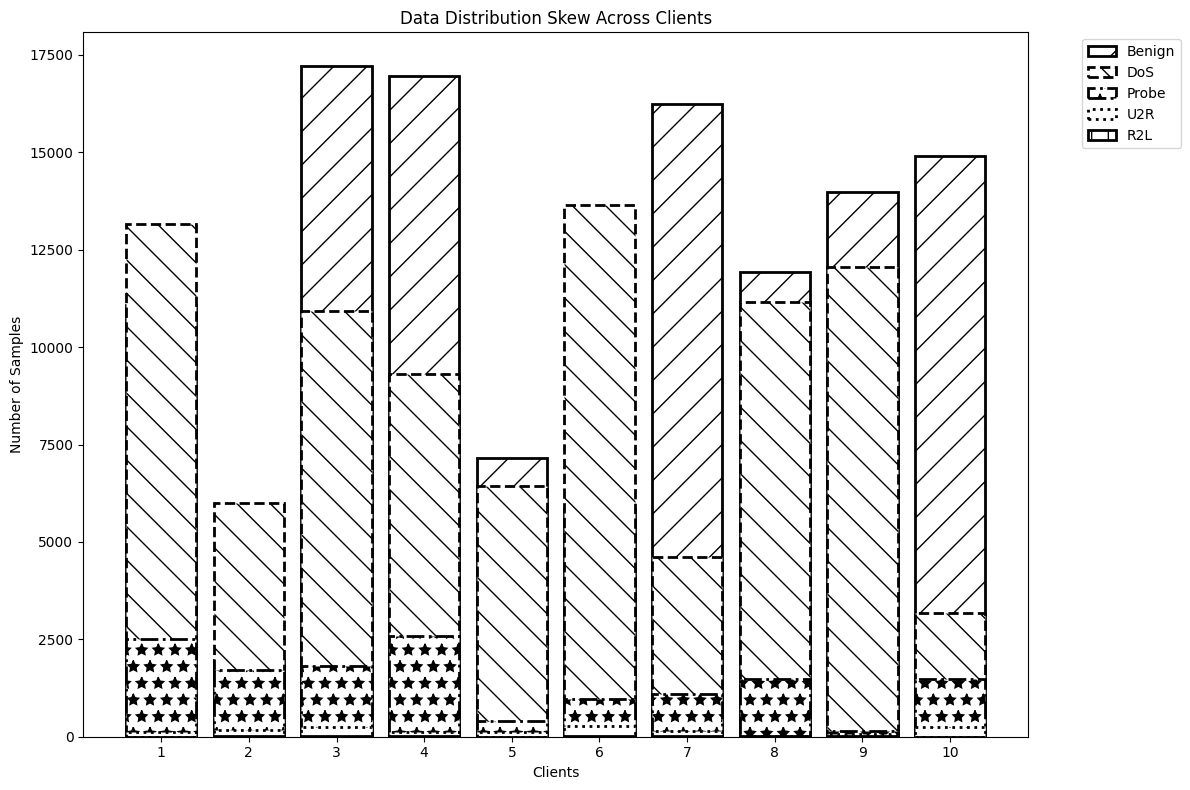

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define class names and partitions
class_names = ['Benign', 'DoS', 'Probe', 'U2R', 'R2L']

# Define partitions
partitions = [
    {'Benign': 11081, 'DoS': 13154, 'Probe': 2508, 'U2R': 120, 'R2L': 3},
    {'Benign': 1969, 'DoS': 5987, 'Probe': 1719, 'U2R': 161, 'R2L': 12},
    {'Benign': 17218, 'DoS': 10931, 'Probe': 1823, 'U2R': 253, 'R2L': 13},
    {'Benign': 16970, 'DoS': 9301, 'Probe': 2587, 'U2R': 110, 'R2L': 9},
    {'Benign': 7142, 'DoS': 6424, 'Probe': 414, 'U2R': 112, 'R2L': 1},
    {'Benign': 5855, 'DoS': 13659, 'Probe': 964, 'U2R': 278, 'R2L': 8},
    {'Benign': 16246, 'DoS': 4619, 'Probe': 1103, 'U2R': 139, 'R2L': 13},
    {'Benign': 11924, 'DoS': 11163, 'Probe': 1489, 'U2R': 21, 'R2L': 12},
    {'Benign': 13988, 'DoS': 12064, 'Probe': 154, 'U2R': 69, 'R2L': 14},
    {'Benign': 14897, 'DoS': 3186, 'Probe': 1480, 'U2R': 240, 'R2L': 1}
]

# Convert partitions to a DataFrame for easier plotting
df_partitions = pd.DataFrame(partitions).fillna(0).astype(int)

# Define distinct patterns for better visibility in black and white
patterns = ['/', '\\', '*', '-', '+']
edge_styles = ['-', '--', '-.', ':', '-']  # Different line styles for edges

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    ax.bar(df_partitions.index, df_partitions[class_name], label=class_name,
           color='white', hatch=patterns[i], edgecolor='black', linewidth=2, linestyle=edge_styles[i])

# Update x-axis labels and other plot settings
ax.set_xticks(df_partitions.index)
ax.set_xticklabels([f'{i+1}' for i in range(len(partitions))])
ax.set_title('Data Distribution Skew Across Clients')
ax.set_xlabel('Clients')
ax.set_ylabel('Number of Samples')

# Place legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to fit everything
plt.tight_layout()

# Save the plot as a PNG image (before plt.show())
plt.savefig('data_skew_black_white.png')

# Display the plot
plt.show()

# Download the plot
from google.colab import files
files.download('data_skew_black_white.png')